In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df1=pd.read_csv('/content/drive/My Drive/Datastorm/Hotel-A-train.csv')
df2=pd.read_csv('/content/drive/My Drive/Datastorm/Hotel-A-validation.csv')
df3=pd.read_csv('/content/drive/My Drive/Datastorm/Hotel-A-test.csv')

In [ ]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)

In [ ]:
df=pd.concat((df1,df2), axis=0)

In [ ]:
df.drop("Reservation-id", axis=1, inplace=True)

In [ ]:
import datetime

In [ ]:
def no_of_dates(x):
    _x = x.split('/')
    _y = datetime.datetime.now() - datetime.datetime(int(_x[2]), int(_x[0]), int(_x[1]))
    _y = _y.days
    return _y
    

In [ ]:
df['Booking_date'] = df['Booking_date'].apply(no_of_dates)
df['Expected_checkin'] = df['Expected_checkin'].apply(no_of_dates)
df['Expected_checkout'] = df['Expected_checkout'].apply(no_of_dates)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
categorical_features = ["Ethnicity", "Educational_Level", "Income", "Country_region", "Adults","Hotel_Type", "Meal_Type", "Visted_Previously", "Previous_Cancellations",
                       "Deposit_type", "Booking_channel", "Required_Car_Parking", "Use_Promotion","Gender"]

continuous_features = ['Expected_checkin', 'Expected_checkout', 'Booking_date','Room_Rate',"Age"]

In [ ]:
for feature in categorical_features:
    df[feature]=LabelEncoder().fit_transform(df[feature])

In [ ]:
df["Reservation_Status"]=LabelEncoder().fit_transform(df["Reservation_Status"])
output_ft = df["Reservation_Status"]
df.drop("Reservation_Status", axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import RobustScaler
scaler=RobustScaler()
df=pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
df["Reservation_Status"] = output_ft.values
df.head()

In [ ]:
df.head()

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model=ExtraTreesClassifier()
model.fit(df.loc[:,df.columns != 'Reservation_Status'] ,df['Reservation_Status'])

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

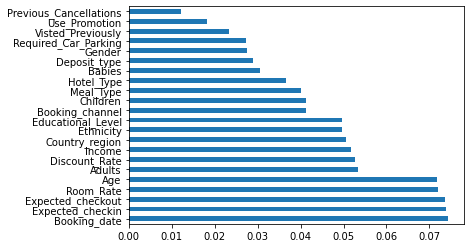

In [ ]:
ranked_features=pd.Series(model.feature_importances_,index=df.loc[:,df.columns != 'Reservation_Status'].columns)
ranked_features.nlargest(28).plot(kind='barh')
plt.show()

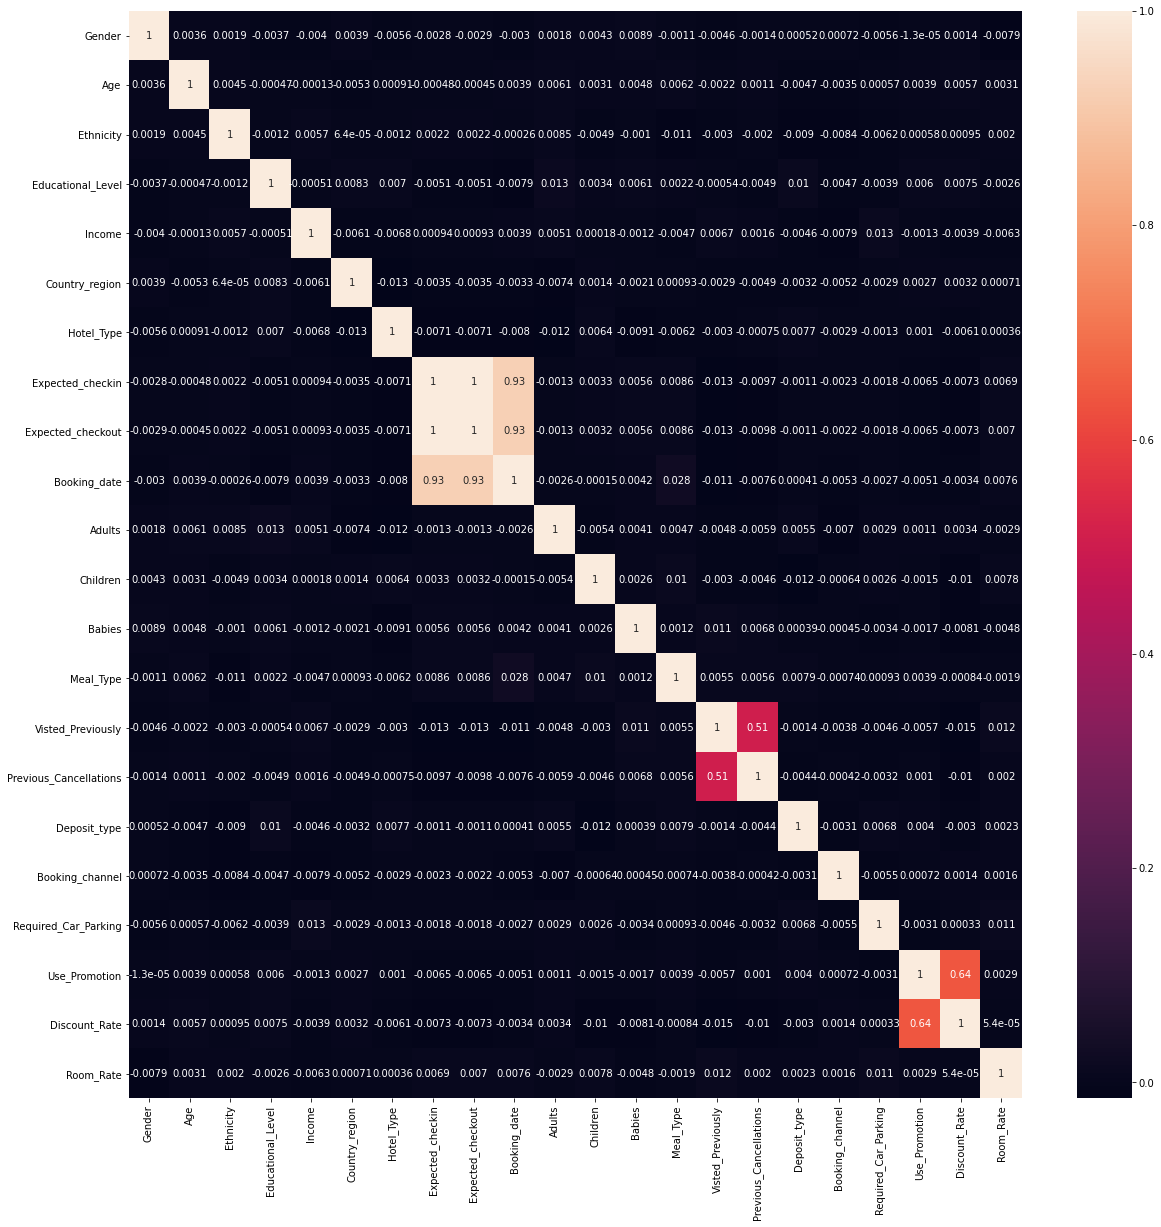

In [ ]:
# corr=df_robust_scaler.corr()
# top_features=corr.index
plt.figure(figsize=(20,20))
sns.heatmap(df.loc[:,df.columns != 'Reservation_Status'].corr(),annot=True)

In [ ]:
threshold=0.6

In [ ]:
def correlation(dataset, threshold):
    col_corr = []
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                colname = corr_matrix.columns[i] 
                tup = (corr_matrix.columns[i], corr_matrix.columns[j])
                col_corr.append(tup)
    return col_corr

In [ ]:
correlation(df.loc[:,df.columns != 'Reservation_Status'],threshold)

[('Expected_checkout', 'Expected_checkin'),
 ('Booking_date', 'Expected_checkin'),
 ('Booking_date', 'Expected_checkout'),
 ('Discount_Rate', 'Use_Promotion')]

In [ ]:
features_to_drop = ['Expected_checkin','Expected_checkout','Use_Promotion']

In [ ]:
categorical_features = ["Ethnicity", "Educational_Level", "Income", "Country_region", "Adults","Hotel_Type", "Meal_Type", "Visted_Previously", "Previous_Cancellations",
                       "Deposit_type", "Booking_channel", "Required_Car_Parking", "Gender"]

continuous_features = ['Booking_date','Room_Rate',"Age"]

In [ ]:
out_feature = df['Reservation_Status']

In [ ]:
### Stacking categorical features
cat_values=np.stack([df[i].values for i in categorical_features],axis=1)

In [ ]:
### Stacking continuous features
cont_values=np.stack([df[i].values for i in continuous_features],axis=1)

In [ ]:
cont_values.shape

(30248, 3)

In [ ]:
### Convert numpy to Tensors
cat_values=torch.tensor(cat_values,dtype=torch.int64)
cont_values=torch.tensor(cont_values,dtype=torch.float)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class FeedForwardNN(nn.Module):

    def __init__(self, no_of_cont_ft, no_of_cat_ft,out_size, layers,p=0.3):
        super().__init__()
        self.bn_cont = nn.BatchNorm1d(no_of_cont_ft)
        self.softmax = nn.Softmax()
        
        layerlist = []
        no_in_col = no_of_cat_ft + no_of_cont_ft
        
        for i in layers:
            layerlist.append(nn.Linear(no_in_col,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            no_in_col = i
        layerlist.append(nn.Linear(layers[-1],out_size))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x_cat, x_cont], 1)
        x = self.layers(x)
        return x

In [ ]:
model=FeedForwardNN(len(continuous_features),len(categorical_features),3,[32,64,128,128,64],p=0.3)

In [ ]:
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
y = torch.tensor(out_feature.values, dtype=torch.long).reshape(-1,1)

In [ ]:
batch_size=df.shape[0]
test_size=int(batch_size*0.25)
train_categorical=cat_values[:batch_size-test_size]
test_categorical=cat_values[batch_size-test_size:batch_size]
train_cont=cont_values[:batch_size-test_size]
test_cont=cont_values[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

In [ ]:
abc = torch.cat((train_categorical, train_cont,y_train), 1)
train = torch.utils.data.DataLoader(abc, batch_size=int(batch_size*0.25), num_workers=0, shuffle=True)

In [ ]:
print(train_categorical.shape)
print(train_cont.shape)
print(y_train.shape)

torch.Size([22686, 13])
torch.Size([22686, 3])
torch.Size([22686, 1])


In [ ]:
EPOCHS=1
final_losses=[]
for i in range(EPOCHS):
    i=i+1
    for data in train:
        y_pred=model(torch.tensor(data[:,:13], dtype=torch.long),data[:,13:-1])
        print(torch.tensor(data[:,-1].flatten(),dtype=torch.long))
        break
        loss=torch.sqrt(loss_function(y_pred,torch.tensor(data[:,-1].flatten(),dtype=torch.long)))
        final_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i%10==0:
        print("Epoch number: {} and the loss : {}".format(i,loss.item()))

tensor([2, 1, 1,  ..., 1, 1, 1])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [ ]:
with torch.no_grad():
    y_pred=model(test_categorical,test_cont)
    loss=torch.sqrt(loss_function(y_pred,y_test.flatten()))
print('RMSE: {}'.format(loss))

In [ ]:
final = [torch.argmax(i).item() for i in y_pred]

In [ ]:
original_out = [i.item() for i in y_test.flatten()]

In [ ]:
y_test.flatten()[10]

In [ ]:
original_out[10]

In [ ]:
from sklearn.metrics import f1_score
print(f1_score(original_out, final, average='macro'))

In [ ]:
df['Reservation_Status'].value_counts()